I want to compare the results of Kraskov MI and the neural estimation one, using different values of k for Kraskov. Specifically, if the actual value of MI is very small, you are not able to estimate it using Kraskov with large k. If you decrease k, you are able to estimate it.

In [114]:
import pandas as pd
import numpy as np
from minepy import MINE
import minepy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_regression
from neural_estimation import MINE
from plot_functions import compute_density, density_scatterplot

from tqdm import tqdm

In [2]:
import warnings; warnings.simplefilter('ignore')

## Import data
I will just use the columns from 318 to the end

In [3]:
data = pd.read_csv("WHO.csv")

# Exclude the first two columns, that are just the name of the country and the ID

data = data.iloc[:,2:]  

reduced_data = data.iloc[:,318:]

## Kraskov MI

In [4]:
from pairwise_dependences import pairwise_kraskov_MI, pairwise_corr

In [5]:
%%time 
pearson_corr = pairwise_corr(reduced_data)

CPU times: user 2.57 ms, sys: 0 ns, total: 2.57 ms
Wall time: 4.63 ms


In [6]:
%%time
kraskov_MI = pairwise_kraskov_MI(reduced_data, n_neighbors=1)

CPU times: user 2 s, sys: 95 µs, total: 2 s
Wall time: 2.01 s


In [7]:
print(sum(kraskov_MI<0), sum(kraskov_MI==-1), sum(kraskov_MI==-2))

37 0 37


In [8]:
valid_indices = kraskov_MI >= 0
print(sum(valid_indices==True))

666


In [9]:
pearson_corr = pearson_corr[valid_indices]
kraskov_MI = kraskov_MI[valid_indices]

# Smoother implementation

In [10]:
n_neighbors = 3

In [11]:
%%time 
pearson_corr = pairwise_corr(reduced_data)

CPU times: user 2.75 ms, sys: 763 µs, total: 3.51 ms
Wall time: 2.63 ms


In [12]:
%%time
kraskov_MI = pairwise_kraskov_MI(reduced_data, n_neighbors=n_neighbors)

CPU times: user 1.86 s, sys: 0 ns, total: 1.86 s
Wall time: 1.86 s


In [13]:
neural_MI = np.load("results/neural_MI_WHO_from_col318_toend.npy")

In [14]:
print(sum(kraskov_MI<0), sum(kraskov_MI==-1), sum(kraskov_MI==-2))

37 0 37


In [15]:
valid_indices = kraskov_MI >= 0
print(sum(valid_indices==True))

666


In [16]:
pearson_corr = pearson_corr[valid_indices]
kraskov_MI = kraskov_MI[valid_indices]
neural_MI = neural_MI[valid_indices]

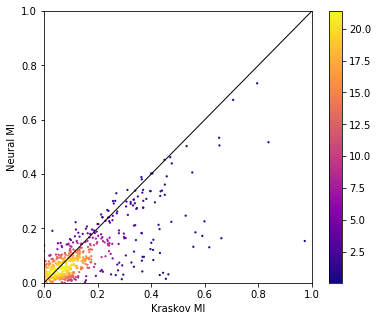

In [18]:
#%%time 
MI_density = compute_density(neural_MI[:,0], kraskov_MI)

fig, ax = density_scatterplot(kraskov_MI, neural_MI[:, 0], MI_density, s=5, size=(6,5))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("Kraskov MI")
plt.ylabel("Neural MI")
ax.plot(np.linspace(0,1), np.linspace(0,1), lw = 1, color="black")
#ax.axhline(0, color="black", lw=1)
#plt.colorbar(fig)
plt.show()
#plt.savefig("images/neural_versus_Kraskov_WHO.png")

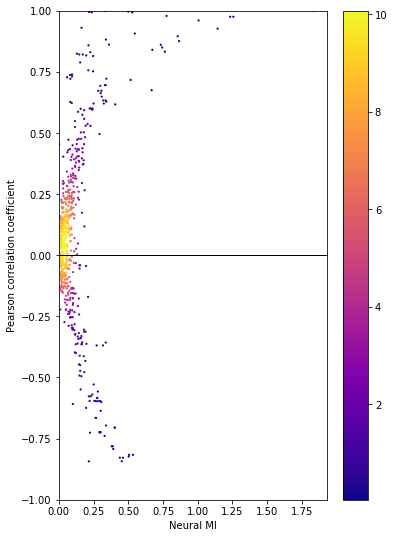

In [19]:
#%%time 
neural_pearson_density = compute_density(neural_MI[:,0], pearson_corr)

#np.save("results/mic_pearson_density", mic_pearson_density)

#mic_pearson_density = np.load("results/mic_pearson_density.npy")

fig, ax = density_scatterplot(neural_MI[:,0], pearson_corr, neural_pearson_density, s=5)
ax.set_xlabel("Neural MI")
ax.set_ylabel("Pearson correlation coefficient")
#x.set_xlim([0,1])
ax.set_xlim(left=0)
ax.set_ylim([-1,1])
ax.axhline(0, color="black", lw=1)
#plt.colorbar(fig)
plt.show()
#plt.savefig("images/pearson_corr_vs_MIC_WHO.png")

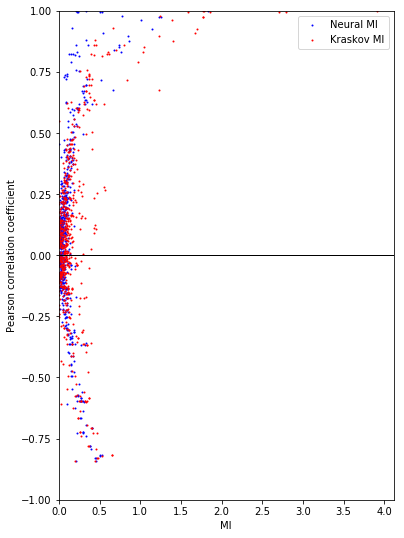

In [22]:
#%%time 
fig, ax = plt.subplots(figsize=(6,9))
ax.scatter(neural_MI[:,0], pearson_corr, color="blue", s=1, label="Neural MI")
ax.scatter(kraskov_MI, pearson_corr, color="red", s=1, label="Kraskov MI")
ax.set_xlabel("MI")
ax.set_ylabel("Pearson correlation coefficient")
#x.set_xlim([0,1])
ax.set_xlim(left=0)
ax.set_ylim([-1,1])
ax.axhline(0, color="black", lw=1)
ax.legend()
#plt.colorbar(fig)
plt.show()
#plt.savefig("images/pearson_corr_vs_MIC_WHO.png")

In [5]:
def compare_kraskov_neural(n_neighbors):
    kraskov_MI = pairwise_kraskov_MI(reduced_data, n_neighbors=n_neighbors)
    neural_MI = np.load("results/neural_MI_WHO_from_col318_toend.npy")
    valid_indices = kraskov_MI >= 0
    kraskov_MI = kraskov_MI[valid_indices]
    neural_MI = neural_MI[valid_indices]
    
    return kraskov_MI, neural_MI

def scatter_plots(kraskov_MI, neural_MI):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(kraskov_MI, neural_MI[:, 0], s=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel("Kraskov MI")
    ax.set_ylabel("Neural MI")
    ax.plot(np.linspace(0,1), np.linspace(0,1), color="orange")
    
    return fig, ax
    

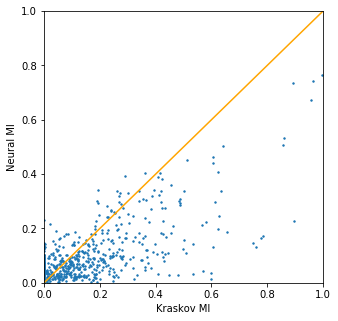

In [33]:
kraskov_MI1, neural_MI1 = compare_kraskov_neural(1)

fig1, ax1 = scatter_plots(kraskov_MI1, neural_MI1)

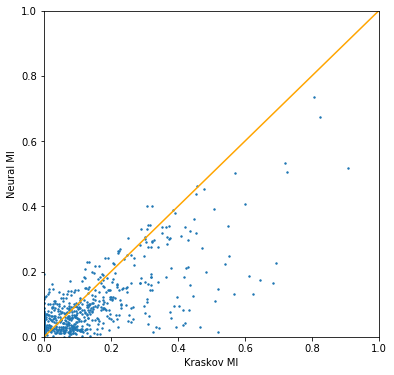

In [61]:
kraskov_MI2, neural_MI2 = compare_kraskov_neural(2)
fig2, ax2 = scatter_plots(kraskov_MI2, neural_MI2)

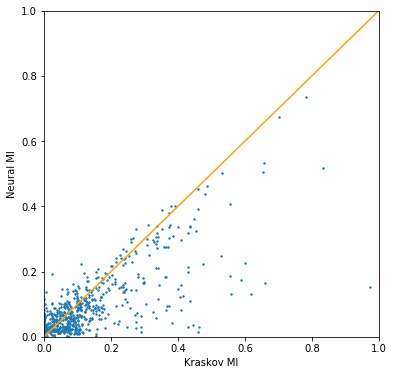

In [62]:
kraskov_MI3, neural_MI3 = compare_kraskov_neural(3)
fig3, ax3 = scatter_plots(kraskov_MI3, neural_MI3)

# Try now with a bivariate Gaussian, for which the mutual information is known:

$ I(x;y) = - { 1 \over 2 } \ln (1 - \rho^2) $


In [259]:
def bivariate_gaussian(rho, size):
    mean = [0,0]
    cov_matrix = [[1, rho], [rho, 1]]
    res = np.random.multivariate_normal(mean, cov_matrix, size)
    x, y = res[:, 0], res[:, 1]
    return x.reshape(-1, 1), y.reshape(-1, 1)

def MI_bivariate_gaussian(rho):
    return -0.5*np.log(1-rho**2)

In [260]:
rho = 0.1

In [261]:
x, y = bivariate_gaussian(rho, 100)

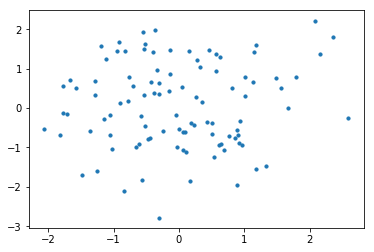

In [262]:
plt.scatter(x, y, s=10)

In [263]:
MI_bivariate_gaussian(rho)

0.005025167926750725

Comparison of the results for different values of k

In [312]:
k_values = [1,2,3,4,5]
rho_values = np.linspace(0, 1, 100)
MI_kraskov = np.zeros((len(k_values), len(rho_values)))

In [313]:
for i, k in enumerate(k_values):
    for j, rho in enumerate(rho_values):
        x, y = bivariate_gaussian(rho, 100)
        MI_kraskov[i, j] = mutual_info_regression(x, y, n_neighbors=k)

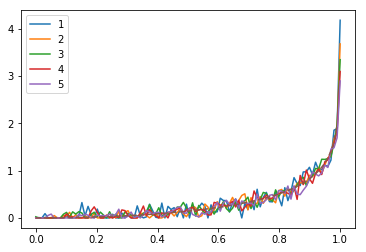

In [314]:
for i in range(len(k_values)):
    plt.plot(rho_values, MI_kraskov[i], label=str(k_values[i]))

plt.plot(rho_values, MI_bivariate_gaussian(rho_values), "--")
plt.legend()

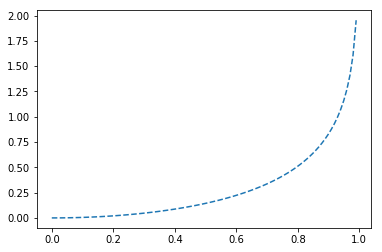

In [315]:
plt.plot(rho_values, MI_bivariate_gaussian(rho_values), "--")

In [316]:
k_values = np.arange(1, 11)
rho_values = np.linspace(0, 1, 5)[0:-1]
MI_kraskov_2 = np.zeros((len(k_values), len(rho_values)))

In [317]:
for i, k in enumerate(k_values):
    for j, rho in enumerate(rho_values):
        x, y = bivariate_gaussian(rho, 100)
        MI_kraskov_2[i, j] = mutual_info_regression(x, y, n_neighbors=k)

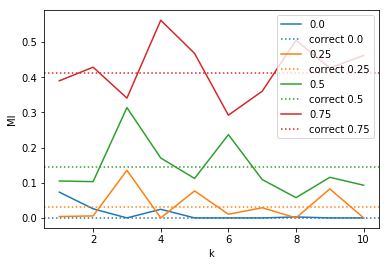

In [320]:
for i in range(len(rho_values)):
    im = plt.plot(k_values, MI_kraskov_2[:,i], label=str(rho_values[i]))
    plt.axhline(MI_bivariate_gaussian(rho_values[i]), label = "correct "+str(rho_values[i]), ls='dotted', color=im[0].get_color())

plt.xlabel("k")
plt.ylabel("MI")    
plt.legend()

In [ ]:
for i in range(len(k_values)):
    plt.plot(rho_values, MI_kraskov[i], label=str(k_values[i]))

plt.plot(rho_values, MI_bivariate_gaussian(rho_values), "--")
plt.legend()

### Compare MINE results with the standard one, for different number of epochs.

In [7]:
MINE(x, y)

NameError: name 'x' is not defined

In [290]:
epochs_values = [200, 400, 600, 800, 1000]
rho_values = np.linspace(0, 1, 5)[0:-1] # exlude rho=1 because you get infinite MI
MI_neural = np.zeros((len(epochs_values), len(rho_values), 2))

In [291]:
for i, epoch in enumerate(epochs_values):
    for j, rho in enumerate(rho_values):
        x, y = bivariate_gaussian(rho, 100)
        MI_neural[i, j] = MINE(x, y, n_epoch=epoch)

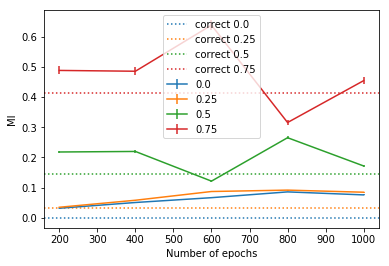

In [319]:
for i in range(len(rho_values)):
    im = plt.errorbar(epochs_values, MI_neural[:,i,0], yerr=MI_neural[:,i,1] , label=str(rho_values[i]))
    plt.axhline(MI_bivariate_gaussian(rho_values[i]), label = "correct "+str(rho_values[i]), ls='dotted', color=im[0].get_color())

plt.xlabel("Number of epochs")
plt.ylabel("MI")    
plt.legend()

# Nice plots:
## Training curve for neural estimator
I draw a bivariate Gaussian with correlation 0.9 and apply neural algorithm. Take 200 points, as it is the same number of samples as the WHO dataset

In [52]:
rho = 0.9
n_epoch = 400
exact_MI = MI_bivariate_gaussian(rho)
x, y = bivariate_gaussian(rho, 200)

In [53]:
neural_MI, var_neural_MI, neural_MI_plot = MINE(x, y, n_epoch=n_epoch, return_loss_plot=True, optimizer="Adam")

In [54]:
var_neural_MI

0.010453320517626237

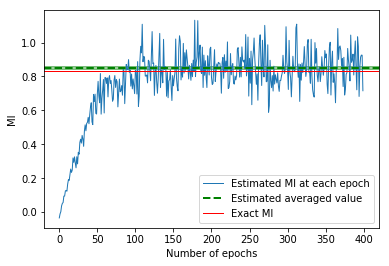

In [64]:
fig, ax = plt.subplots()
ax.plot(neural_MI_plot, lw=1, label = "Estimated MI at each epoch")
ax.axhline(y=neural_MI, color="green", ls="dashed", lw=2, label="Estimated averaged value")
ax.fill_between(np.linspace(-0.05*n_epoch, n_epoch*1.05), neural_MI-var_neural_MI, neural_MI+var_neural_MI, alpha=0.4, color="green")
ax.axhline(y=exact_MI, color="red", ls="-", lw=1, label="Exact MI")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("MI")
ax.set_xlim((-0.05*n_epoch, n_epoch*1.05))
ax.legend()

Still, the estimated value has not to be compared with the real one but also with the results one obtains using standard Kraskov algorithm
## Relative difference for various $\rho$ between neural and Kraskov estimate
Consider a fixed `k` and `n_epochs`

In [235]:
#k_values = [1,2,3,4,5]

#rho_values = np.log10(np.linspace(1, 10, 100))  # in this way I get many points close to 1
rho_values = np.linspace(0, 1, 100)

k=3
MI_kraskov = np.zeros((len(rho_values)))

n_epoch = 400
MI_neural = np.zeros((len(rho_values), 2))

In [237]:
rho_values

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [238]:
#for i, k in enumerate(k_values):
for j, rho in tqdm(enumerate(rho_values)):
    x, y = bivariate_gaussian(rho, 200)
    MI_kraskov[j] = mutual_info_regression(x, y, n_neighbors=k)
    MI_neural[j] = MINE(x, y, n_epoch=n_epoch)

100it [00:45,  2.31it/s]


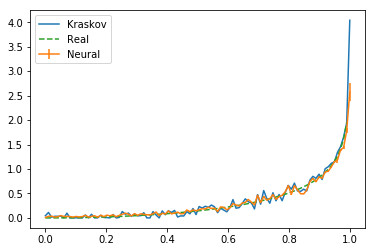

In [239]:
#for i in range(len(k_values)):
plt.plot(rho_values, MI_kraskov, label="Kraskov")
im = plt.errorbar(rho_values, MI_neural[:,0], yerr=MI_neural[:,1] , label="Neural")
plt.plot(rho_values, MI_bivariate_gaussian(rho_values), "--", label="Real")
plt.legend()

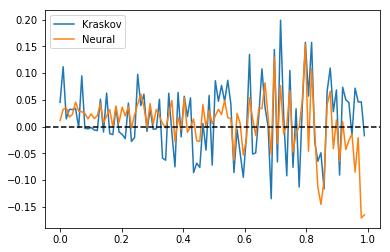

In [244]:
#for i in range(len(k_values)):
plt.plot(rho_values, (MI_kraskov-MI_bivariate_gaussian(rho_values)), label="Kraskov")
im = plt.plot(rho_values, (MI_neural[:,0]-MI_bivariate_gaussian(rho_values)), label="Neural")
#plt.plot(rho_values, MI_bivariate_gaussian(rho_values), "--", label="Real")
plt.axhline(0, ls="--", color="black")
plt.legend()

In [247]:
MI_bivariate_gaussian(rho_values)[10:]

array([0.00512772, 0.00621126, 0.00740069, 0.00869677, 0.01010031,
       0.01161223, 0.01323348, 0.01496513, 0.01680831, 0.01876422,
       0.02083418, 0.02301957, 0.02532187, 0.02774266, 0.03028362,
       0.03294652, 0.03573326, 0.03864584, 0.04168637, 0.0448571 ,
       0.0481604 , 0.05159877, 0.05517488, 0.05889152, 0.06275165,
       0.06675841, 0.0709151 , 0.07522521, 0.07969246, 0.08432073,
       0.08911416, 0.09407713, 0.09921427, 0.10453048, 0.11003094,
       0.11572118, 0.12160702, 0.12769468, 0.13399074, 0.14050221,
       0.14723655, 0.1542017 , 0.16140613, 0.16885889, 0.17656964,
       0.18454873, 0.19280723, 0.20135704, 0.21021091, 0.21938261,
       0.22888693, 0.23873986, 0.24895871, 0.25956221, 0.27057072,
       0.28200637, 0.29389333, 0.306258  , 0.31912934, 0.33253917,
       0.34652258, 0.36111838, 0.37636964, 0.39232434, 0.40903614,
       0.42656529, 0.44497976, 0.46435663, 0.48478376, 0.50636194,
       0.52920746, 0.55345555, 0.57926466, 0.60682215, 0.63635

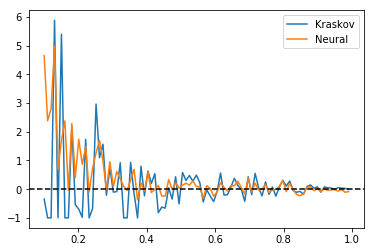

In [250]:
#for i in range(len(k_values)):
plt.plot(rho_values[10:], (MI_kraskov[10:]-MI_bivariate_gaussian(rho_values[10:]))/MI_bivariate_gaussian(rho_values[10:]), label="Kraskov")
im = plt.plot(rho_values[10:], (MI_neural[10:,0]-MI_bivariate_gaussian(rho_values[10:]))/MI_bivariate_gaussian(rho_values[10:]), label="Neural")
#plt.plot(rho_values, MI_bivariate_gaussian(rho_values), "--", label="Real")
plt.axhline(0, ls="--", color="black")
plt.legend()

## Plot for the WHO dataset

In [157]:
n_neighbors = 3

In [158]:
%%time 
pearson_corr = pairwise_corr(reduced_data)

CPU times: user 3.57 ms, sys: 37 µs, total: 3.61 ms
Wall time: 2.4 ms


In [159]:
%%time
kraskov_MI_2 = pairwise_kraskov_MI(reduced_data, n_neighbors=n_neighbors)

CPU times: user 1.89 s, sys: 9 µs, total: 1.89 s
Wall time: 1.89 s


In [160]:
neural_MI_2 = np.load("results/neural_MI_WHO_from_col318_toend.npy")

In [161]:
print(sum(kraskov_MI_2<0), sum(kraskov_MI_2==-1), sum(kraskov_MI_2==-2))

37 0 37


In [162]:
valid_indices = kraskov_MI_2 >= 0
print(sum(valid_indices==True))

666


In [163]:
pearson_corr = pearson_corr[valid_indices]
kraskov_MI_2 = kraskov_MI_2[valid_indices]
neural_MI_2 = neural_MI_2[valid_indices]

In [254]:
positive_indices = pearson_corr >= 0
negative_indices = pearson_corr < 0

In [273]:
pearson_corr_pos = pearson_corr[positive_indices]
kraskov_MI_2_pos = kraskov_MI_2[positive_indices]
neural_MI_2_pos = neural_MI_2[positive_indices, 0]

pearson_corr_neg = pearson_corr[negative_indices]
kraskov_MI_2_neg = kraskov_MI_2[negative_indices]
neural_MI_2_neg = neural_MI_2[negative_indices, 0]

In [274]:
z_pos_kraskov = np.polyfit(pearson_corr_pos, kraskov_MI_2_pos , 2)
z_neg_kraskov = np.polyfit(pearson_corr_neg, kraskov_MI_2_neg , 2)

z_pos_neural = np.polyfit(pearson_corr_pos, neural_MI_2_pos , 2)
z_neg_neural = np.polyfit(pearson_corr_neg, neural_MI_2_neg , 2)

In [276]:
val_pos_kraskov = np.polyval(z_pos_kraskov, np.linspace(0, 1, 100))
val_neg_kraskov = np.polyval(z_neg_kraskov, np.linspace(-1, 0, 100))

val_pos_neural = np.polyval(z_pos_neural, np.linspace(0, 1, 100))
val_neg_neural = np.polyval(z_neg_neural, np.linspace(-1, 0, 100))

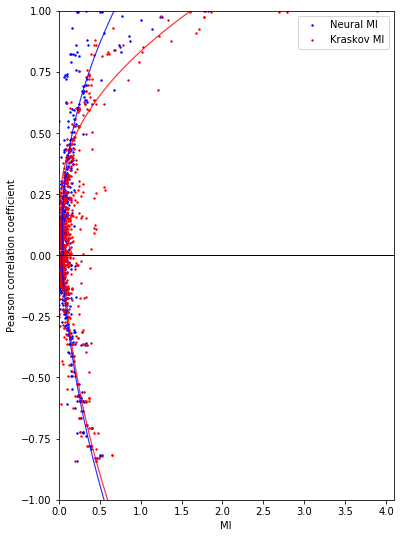

In [288]:
#%%time 
fig, ax = plt.subplots(figsize=(6,9))
ax.scatter(neural_MI_2[:,0], pearson_corr, color="blue", s=2, label="Neural MI")
ax.scatter(kraskov_MI_2, pearson_corr, color="red", s=2, label="Kraskov MI")

lw=1.2
alpha=0.8

ax.plot(val_pos_kraskov, np.linspace(0, 1, 100), color="red", lw=lw, alpha=alpha)
ax.plot(val_neg_kraskov, np.linspace(-1, 0, 100), color="red", lw=lw, alpha=alpha)
ax.plot(val_pos_neural, np.linspace(0, 1, 100), color="blue", lw=lw, alpha=alpha)
ax.plot(val_neg_neural, np.linspace(-1, 0, 100), color="blue", lw=lw, alpha=alpha)



ax.set_xlabel("MI")
ax.set_ylabel("Pearson correlation coefficient")

#x.set_xlim([0,1])
ax.set_xlim(left=0)
ax.set_ylim([-1,1])
ax.axhline(0, color="black", lw=1)
ax.legend()
#plt.colorbar(fig)
plt.show()
#plt.savefig("images/pearson_corr_vs_MIC_WHO.png")

## Arrange the plots in a fancy way

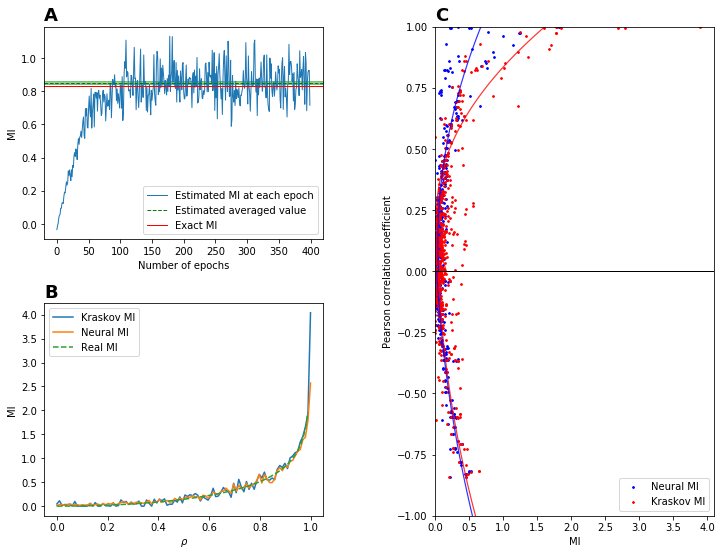

In [291]:
size = np.array([12,9])

fontdict = {'fontsize': 18,           
 'fontweight' : 'bold',
 'verticalalignment': 'baseline'}
 #'horizontalalignment': -12}

fig = plt.figure(figsize=(size[0], size[1]))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
WHO_ax = fig.add_subplot(grid[:, 1])
ax_1 = fig.add_subplot(grid[0, 0])#, xticklabels=[], sharey=main_ax)
ax_2 = fig.add_subplot(grid[1, 0])#, yticklabels=[], sharex=main_ax)

ax_1.set_title("A", loc="left", fontdict=fontdict)
ax_1.plot(neural_MI_plot, lw=1, label = "Estimated MI at each epoch")
ax_1.axhline(y=neural_MI, color="green", ls="dashed", lw=1, label="Estimated averaged value")
ax_1.fill_between(np.linspace(-0.05*n_epoch, n_epoch*1.05), neural_MI-var_neural_MI, neural_MI+var_neural_MI, alpha=0.4, color="green")
ax_1.axhline(y=exact_MI, color="red", ls="-", lw=1, label="Exact MI")
ax_1.set_xlabel("Number of epochs")
ax_1.set_ylabel("MI")
ax_1.set_xlim((-0.05*n_epoch, n_epoch*1.05))
ax_1.legend()

ax_2.set_title("B", loc="left", fontdict=fontdict)
ax_2.plot(rho_values, MI_kraskov, label="Kraskov MI")
im = ax_2.plot(rho_values, MI_neural[:,0], label="Neural MI")
ax_2.plot(rho_values, MI_bivariate_gaussian(rho_values), "--", label="Real MI")
ax_2.set_xlabel(r"$\rho$")
ax_2.set_ylabel("MI")
ax_2.legend()

WHO_ax.set_title("C", loc="left", fontdict=fontdict)
WHO_ax.scatter(neural_MI_2[:,0], pearson_corr, color="blue", s=3, label="Neural MI")
WHO_ax.scatter(kraskov_MI_2, pearson_corr, color="red", s=3, label="Kraskov MI")
lw=1.2
alpha=0.8

WHO_ax.plot(val_pos_kraskov, np.linspace(0, 1, 100), color="red", lw=lw, alpha=alpha)
WHO_ax.plot(val_neg_kraskov, np.linspace(-1, 0, 100), color="red", lw=lw, alpha=alpha)
WHO_ax.plot(val_pos_neural, np.linspace(0, 1, 100), color="blue", lw=lw, alpha=alpha)
WHO_ax.plot(val_neg_neural, np.linspace(-1, 0, 100), color="blue", lw=lw, alpha=alpha)

WHO_ax.set_xlabel("MI")
WHO_ax.set_ylabel("Pearson correlation coefficient")
#x.set_xlim([0,1])
WHO_ax.set_xlim(left=0)
WHO_ax.set_ylim([-1,1])
WHO_ax.axhline(0, color="black", lw=1)
WHO_ax.legend(loc="lower right")

#plt.text(0,0,"a)", )

#plt.colorbar(fig)
plt.savefig("images/neural_vs_Kraskov.pdf")

plt.show()
